# Libraries

In [ ]:
# Packages for dataframe operations
import numpy as np 
import pandas as pd
# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import collections

import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
import pickle
import nltk

## Import DataSet for 2021

In [4]:
df = pd.read_csv('data_2021.csv') 

In [5]:
df

,Post,Name,Datetime,Story,year
0,post-7139982,June132017,"Jul 14, 2021 at 1:27 AM",A guy named Russel ordered a Lyft. So looking ...,2021
1,post-7137806,Bojingles,"Jul 12, 2021 at 5:15 PM",My account has never been placed on hold for a...,2021
2,post-7136004,MissAnne,"Jul 10, 2021 at 8:40 PM",Guess things in Salt Lake City are getting bac...,2021
3,post-7029729,touberornottouber,"Apr 14, 2021 at 12:00 PM",I get a ride request to go to an apartment. Wh...,2021
4,post-7129924,losiglow,"Jul 4, 2021 at 4:19 PM",I thought a thread dedicated to funny screensh...,2021
...,...,...,...,...,...
375,post-6733635,FLKeys,"Jan 4, 2021 at 12:08 PM",Saturday night I picked up a PAX and in our di...,2021
376,post-6727401,goneubering,"Jan 2, 2021 at 2:24 AM",\nMost of the students enrolled at Lynhurst Ba...,2021
377,post-6724571,Ozzyoz,"Jan 1, 2021 at 1:48 AM",It is a Q symbol instead of U but has same loo...,2021
378,post-6725137,Safar,"Jan 1, 2021 at 10:04 AM","Works well for me though lol, specially when t...",2021


### Set Mallet Path

In [8]:
MALLET_PATH = '/Users/phoebekalochoritou/Downloads/mallet-2.0.8/bin/mallet'

#### Set stories as data 

In [10]:
data = df.Story

In [11]:
data

0      A guy named Russel ordered a Lyft. So looking ...
1      My account has never been placed on hold for a...
2      Guess things in Salt Lake City are getting bac...
3      I get a ride request to go to an apartment. Wh...
4      I thought a thread dedicated to funny screensh...
                             ...                        
375    Saturday night I picked up a PAX and in our di...
376    \nMost of the students enrolled at Lynhurst Ba...
377    It is a Q symbol instead of U but has same loo...
378    Works well for me though lol, specially when t...
379    So yesterday I was working general dispatch ca...
Name: Story, Length: 380, dtype: object

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['guy', 'named', 'russel', 'ordered', 'lyft', 'so', 'looking', 'at', 'the', 'map', 'it', 'pretty', 'much', 'was', 'making', 'turn', 'down', 'the', 'road', 'so', 'happen', 'to', 'pull', 'over', 'to', 'power', 'station', 'where', 'guess', 'the', 'trucks', 'service', 'them', 'anyway', 'this', 'shaved', 'over', 'miles', 'off', 'his', 'pickup', 'and', 'probably', 'mins', 'well', 'it', 'wasn', 'meant', 'to', 'be', 'he', 'then', 'cancelled', 'after', 'to', 'seconds', 'literally', 'face', 'palmed', 'guess', 'it', 'like', 'hitting', 'homerun', 'and', 'losing', 'couple', 'of', 'times', 'made', 'wrong', 'move', 'and', 'made', 'the', 'pickup', 'longer', 'and', 'the', 'rider', 'didn', 'even', 'cancel', 'these', 'free', 'cancels', 'just', 'suck']]


# Building models

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['guy', 'named', 'russel', 'ordered', 'lyft', 'so', 'looking', 'at', 'the', 'map', 'it', 'pretty', 'much', 'was', 'making', 'turn', 'down', 'the', 'road', 'so', 'happen', 'to', 'pull', 'over', 'to', 'power', 'station', 'where', 'guess', 'the', 'trucks', 'service', 'them', 'anyway', 'this', 'shaved', 'over', 'miles', 'off', 'his', 'pickup', 'and', 'probably', 'mins', 'well', 'it', 'wasn', 'meant', 'to', 'be', 'he', 'then', 'cancelled', 'after', 'to', 'seconds', 'literally', 'face', 'palmed', 'guess', 'it', 'like', 'hitting', 'homerun', 'and', 'losing', 'couple', 'of', 'times', 'made', 'wrong', 'move', 'and', 'made', 'the', 'pickup', 'longer', 'and', 'the', 'rider', 'didn', 'even', 'cancel', 'these', 'free', 'cancels', 'just', 'suck']


# Stopwords

## Define them

In [ ]:
nltk.download('stopwords') 
stopwords = nltk.corpus.stopwords.words('english')
stop_words = list(stopwords)
extra = ['uber', 'driver','one', 'provide', 'include', 'works', 'also', 'look', 'another', 'extra', 'someone', 'fact',
         'think', 'everyone', 'since', 'ever', 'likely', 'maybe', 'lot', 'would', 'like', 'mean', 'say',
         'though', 'want', 'guy', 'stil', 'however', 'said', ' ', 'work', 'job', 'year', 'try', 'decide',
         'move', 'obviously', 'man', 'woman', '+', 'literally', '>', '<', 'keep', 'thing', 'look', 'ok',
         'living', 'instead', 'home', 'yesterday', 'today', 'see', 'fall', 'na', 'lady', 'girl', 'probably',
         'guess', 'legit', 'somebody', 'someone', 'know', 'something', 'start', 'much', 'even', 'trying',
         'lol', 'call', 'around', 'every', 'minute', 'according', 'need', 'could', 'back', 'used', 'two',
         'first', 'taking', 'become', 'actually', 'next', 'real', 'go', 'sure', 'yet', 'pick', 'anything',
         'without', 'with', 'got', 'put', 'read', 'come', 'might', 'driver', 'says', 'nothing', 'using',
         'going', 'getting', 'use', 'already', 'paying', 'believe', 'get', 'make', 'u', 'really', 'saying',
         'ask', 'happening', 'may', 'alway', 'still', 'left', 'person', 'drivers', 'people', 'driving', 'long',
         'dont', 'happen', 'told', 'tell', 'women', 'yeah', 'post', 'mr', 'simply', 'show', 'place', 'always',
         'usually', 'sometimes', 'way', 'things', 'many', 'exactly', 'called', 'call', 'give', 'thought', 'either',
         'rider', 'gets', 'last', 'ye', 'whether', 'unless', 'looking', 'means', 'went', 'wants', 'want',
         'seen', 'comes', 'etc', 'asked', 'self', 'tnc', 'the', 'makes', 'hand', 'found', 'find', 'must', 'took',
         'made', 'companie', 'seem', 'friend', 'example', 'name', 'feel', 'including', 'others', 'other', 'started',
         'able', 'leave', 'else', 'or', 'take', 'yes', 'anyone', 'seems', 'comment', 'new', 'pax', 'Hello', 'ok', 'got', 'so', 'it', 'is', 'its', 'guess', 'we',
         'my', 'but', 'too', 'a', 'and', 'today', 'get', 'go','work', 'nan', 'forward', 'ahead', 'send', 'resume', 'car', 'tell', 'ask', 'driver', 'uber', 'list', 'know', 'take', 'minute', 'outta', 'express', 'see', 'the', 'specific', 'accurate',
         'say', 'op', 'be', 'less_than', 'door', 'back', 'pull',  'endless', 'cracker', 'uber', 'drive', 'pax',
         'admire', '$', 'end' 'car', 'driver', 'drive', 'fitting', 'glamorous', 'cute', 'effective',
         'champ', 'certain', 'gave', 'day', 'weeks', 'finally', 'front', 'rides', 'open', 'full', 'story', 'end', 'decided']

stop_words.extend(extra)

## Remove them

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['name', 'order', 'pretty', 'make', 'turn', 'road', 'power', 'station', 'truck', 'service', 'anyway', 'shave', 'mile', 'pickup', 'min', 'well', 'mean', 'cancel', 'second', 'face', 'palm', 'hit', 'homerun', 'lose', 'couple', 'time', 'wrong', 'pickup', 'long', 'cancel', 'free', 'cancel', 'suck']]


# Dictionary

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]]


In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('anyway', 1),
  ('cancel', 3),
  ('couple', 1),
  ('face', 1),
  ('free', 1),
  ('hit', 1),
  ('homerun', 1),
  ('long', 1),
  ('lose', 1),
  ('make', 1),
  ('mean', 1),
  ('mile', 1),
  ('min', 1),
  ('name', 1),
  ('order', 1),
  ('palm', 1),
  ('pickup', 2),
  ('power', 1),
  ('pretty', 1),
  ('road', 1),
  ('second', 1),
  ('service', 1),
  ('shave', 1),
  ('station', 1),
  ('suck', 1),
  ('time', 1),
  ('truck', 1),
  ('turn', 1),
  ('well', 1),
  ('wrong', 1)]]

# LDA models

In [21]:
n_topics = 10

# model estimation
lda_mallet = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus = corpus,
                                              num_topics = n_topics,
                                              id2word = id2word,
                                              random_seed = 1234)

# print results
lda_mallet.print_topics(num_topics = n_topics, num_words = 10)

[(0,
  '0.155*"ride" + 0.031*"app" + 0.030*"pickup" + 0.030*"request" + 0.029*"message" + 0.024*"airport" + 0.023*"tip" + 0.023*"stop" + 0.022*"hour" + 0.017*"realize"'),
 (1,
  '0.033*"night" + 0.025*"stop" + 0.024*"eat" + 0.021*"month" + 0.018*"hard" + 0.016*"make" + 0.015*"sound" + 0.015*"kind" + 0.014*"pass" + 0.014*"play"'),
 (2,
  '0.078*"trip" + 0.045*"mile" + 0.044*"drop" + 0.036*"time" + 0.029*"ping" + 0.024*"check" + 0.024*"destination" + 0.022*"surge" + 0.021*"end" + 0.020*"pick"'),
 (3,
  '0.057*"pay" + 0.045*"time" + 0.038*"tip" + 0.037*"hour" + 0.022*"delivery" + 0.022*"offer" + 0.017*"service" + 0.017*"rate" + 0.016*"part" + 0.015*"accept"'),
 (4,
  '0.033*"talk" + 0.024*"pandemic" + 0.022*"pick" + 0.020*"girlfriend" + 0.019*"young" + 0.019*"year" + 0.019*"feel" + 0.019*"life" + 0.016*"share" + 0.015*"great"'),
 (5,
  '0.065*"good" + 0.040*"area" + 0.030*"money" + 0.021*"week" + 0.020*"day" + 0.018*"work" + 0.018*"time" + 0.017*"company" + 0.017*"cost" + 0.015*"break"'),

# LDA Vis

In [22]:
#from mallet to gensim
lda_mallet_g = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

In [24]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_mallet_g, corpus, id2word)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.202383  0.023531       1        1  10.566277
8      0.226891 -0.004512       2        1  10.533802
7      0.086976  0.123842       3        1  10.428405
5      0.029308 -0.114048       4        1  10.128591
2      0.021205 -0.085311       5        1  10.059533
9     -0.060605  0.232760       6        1   9.803116
6      0.111458 -0.204694       7        1   9.722416
1     -0.118296  0.262541       8        1   9.631882
0     -0.248841 -0.011381       9        1   9.603279
3     -0.250478 -0.222727      10        1   9.522699, topic_info=       Term        Freq       Total Category  logprob  loglift
76     ride  283.000000  283.000000  Default  30.0000  30.0000
311    trip  148.000000  148.000000  Default  29.0000  29.0000
66   minute  141.000000  141.000000  Default  28.0000  28.0000
71    phone  139.000000  139.000000  Default  27.0000  27.0000
98     good  127.000000  127.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
25     time   80.765379  208.229219  Topic10  -3.1120   1.4044
586     fee   25.446626   39.995564  Topic10  -4.2670   1.8993
650  accept   26.553001   46.733513  Topic10  -4.2244   1.7862
227    high   19.914751   35.523430  Topic10  -4.5121   1.7728
4      free   13.276501   23.671296  Topic10  -4.9175   1.7732

[626 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
142       2  0.905281          ac
650       8  0.021398      accept
650       9  0.406560      accept
650      10  0.577744      accept
651       9  1.042459  acceptance
...     ...       ...         ...
1566      3  0.969561       write
29        2  1.000574       wrong
426       1  0.988136        year
1317      3  1.036892        yell
322       1  0.988136       young

[690 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 8, 6, 3, 10, 7, 2, 1, 4])

## Observe topics over Stories

In [25]:
def format_topics_sentences(ldamodel=lda_mallet_g, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_mallet_g, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.1605,"minute, phone, wait, cancel, turn, passenger, ...",A guy named Russel ordered a Lyft. So looking ...
1,1,9.0,0.1157,"run, big, road, hit, food, window, car, proble...",My account has never been placed on hold for a...
2,2,0.0,0.1218,"ride, app, pickup, request, message, airport, ...",Guess things in Salt Lake City are getting bac...
3,3,0.0,0.2025,"ride, app, pickup, request, message, airport, ...",I get a ride request to go to an apartment. Wh...
4,4,0.0,0.1543,"ride, app, pickup, request, message, airport, ...",I thought a thread dedicated to funny screensh...
5,5,6.0,0.2140,"order, customer, vehicle, restaurant, friend, ...","Hello all,\nI drive in Chicago, and today I ha..."
6,6,5.0,0.1711,"good, area, money, week, day, work, time, comp...","\n\n\nAs some know here, I decided to go and g..."
7,7,1.0,0.1368,"night, stop, eat, month, hard, make, sound, ki...",Ok we all know that Lyft is ripping everyone o...
8,8,5.0,0.1338,"good, area, money, week, day, work, time, comp...",A 17-year-old girl has been accused of stabbi...
9,9,0.0,0.2277,"ride, app, pickup, request, message, airport, ...",I figured it wasn't worth doing. Probably 10 m...


## Create Word Clouds

In [26]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

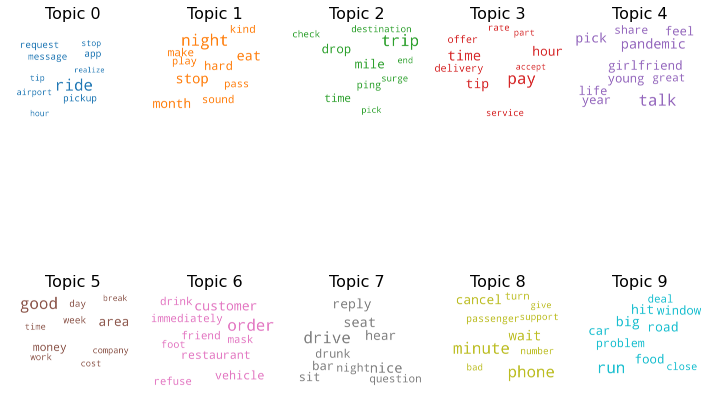

In [29]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_mallet_g.show_topics(formatted = False)

fig, axes = plt.subplots(2,5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Further topic Analysis

In [30]:
#extra libraries
from textblob import TextBlob
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [31]:
#create new columns for polarity
df['polarity'] = df['Story'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['Story'].astype(str).apply(len)
df['word_count'] = df['Story'].apply(lambda x: len(str(x).split()))
df

,Post,Name,Datetime,Story,year,polarity,review_len,word_count
0,post-7139982,June132017,"Jul 14, 2021 at 1:27 AM",A guy named Russel ordered a Lyft. So looking ...,2021,0.038889,533,104
1,post-7137806,Bojingles,"Jul 12, 2021 at 5:15 PM",My account has never been placed on hold for a...,2021,0.000000,124,21
2,post-7136004,MissAnne,"Jul 10, 2021 at 8:40 PM",Guess things in Salt Lake City are getting bac...,2021,0.123611,239,49
3,post-7029729,touberornottouber,"Apr 14, 2021 at 12:00 PM",I get a ride request to go to an apartment. Wh...,2021,0.072727,1367,282
4,post-7129924,losiglow,"Jul 4, 2021 at 4:19 PM",I thought a thread dedicated to funny screensh...,2021,0.101518,941,174
...,...,...,...,...,...,...,...,...
375,post-6733635,FLKeys,"Jan 4, 2021 at 12:08 PM",Saturday night I picked up a PAX and in our di...,2021,0.092659,2795,565
376,post-6727401,goneubering,"Jan 2, 2021 at 2:24 AM",\nMost of the students enrolled at Lynhurst Ba...,2021,0.237500,1984,345
377,post-6724571,Ozzyoz,"Jan 1, 2021 at 1:48 AM",It is a Q symbol instead of U but has same loo...,2021,0.000000,74,17
378,post-6725137,Safar,"Jan 1, 2021 at 10:04 AM","Works well for me though lol, specially when t...",2021,0.369048,73,14


In [39]:
print('2 random reviews with the highest positive sentiment polarity: \n')
cl = df.loc[df.polarity > 0.6, ['Story']].sample(2).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 


So yesterday I gave Katie Boulter and her coach a ride to their hotel after her match. (She won her first two matches.) What a gorgeous- and very sweet- girl!! Her coach is from Spain. Here's a photo! Loving the gig this week.
I just coined the term  to refer to a trucker, LOL.





In [40]:
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = df.loc[df.polarity < 0.1, ['Story']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

Last night I took two very tipsy girls from one of the local college bars to their home out west of the city. I'm from that area, so I asked if they went to Meriwether Lewis Elementary, Henley M.S. and Western Albemarle H.S.

Hilarious answers; "Yes! And we STILL go to Western!"

There are underage kids by the thousands getting into bars with fake ID'S; typical fake ID'S these days are very good and can be nearly impossible to differentiate from genuine ID'S. Cracking down on that reality is clearly not a priority in a college town, although some years ago there was a large bust of a very sophisticated fake ID operation being run right in the heart of the fraternity area here in Charlottesville.










Back in my younger days, I picked up this couple. The girl was actually pretty cute, but she was like 40. Me and her hit it off. 

Her husband was a moron. He spilled pizza on himself and shit. So I had a drink with he

## Plotting Sentiment Polarity Distribution

In [42]:
df['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

## Top 20 words mentioned

In [43]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Story'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Story' , 'count'])
df2.groupby('Story').sum()['count'].sort_values(ascending=False).iplot(
kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

uber 321
pax 305
just 272
ride 259
car 238
said 233
like 226
got 201
time 147
did 146
drivers 129
minutes 128
phone 121
don 118
driver 114
told 112
drive 110
trip 110
know 108
pick 103


## Top 20 trigrams

In [44]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Story'], 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['Story' , 'count'])
df6.groupby('Story').sum()['count'].sort_values(ascending=False).iplot(
kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams')

rear view mirror 5
long story short 5
bla bla bla 4
uber pro points 3
left phone car 3
big greasy heather 3
blah blah blah 3
night got ping 3
driving uber lyft 3
just dropped pax 3
past saturday night 3
young college age 3
benefits outweigh costs 3
uber lyft drivers 3
completely smash drunk 3
chicago botanical gardens 3
surge seen year 2
wasn wearing mask 2
17 year old 2
driver national city 2
